In [5]:
# Machine Learning Algorithms (NOT used in class)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data handling + preprocessing
import pandas as pd
import numpy as np

# Train/test split + evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Optional: ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Optional: nicer display settings for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)

print("Setup complete. Libraries loaded successfully.")

Setup complete. Libraries loaded successfully.


In [6]:
# Load main athlete data
df = pd.read_csv("athlete_events.csv")

# Load NOC regions
noc = pd.read_csv("noc_regions.csv")

# Merge to add 'region' column based on NOC code
df = df.merge(noc, on="NOC", how="left")

print("Data shape after merge:", df.shape)
df[["NOC", "region"]].head()

Data shape after merge: (271116, 17)


,NOC,region
0,CHN,China
1,CHN,China
2,DEN,Denmark
3,DEN,Denmark
4,NED,Netherlands


In [7]:
# Focus on Summer Olympics (optional but common)
df = df[df["Season"] == "Summer"]

# Binary target: 1 if any medal, 0 if no medal
df["Medal_binary"] = df["Medal"].notna().astype(int)

# Basic numeric features
numeric_features = ["Age", "Height", "Weight", "Year"]

# Keep rows with no missing values in chosen features + region + target
df_model = df.dropna(subset=numeric_features + ["region", "Medal_binary"])

# One-hot encode region
region_dummies = pd.get_dummies(df_model["region"], prefix="region")

# Final feature matrix X and target y
X = pd.concat([df_model[numeric_features], region_dummies], axis=1)
y = df_model["Medal_binary"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (166436, 209)
y shape: (166436,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 133148
Test size: 33288


In [9]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.3f}")

XGBoost Accuracy: 0.851


In [10]:
# Model 2: LightGBM using NumPy arrays to avoid feature name issues
lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Note the .values here
lgbm_model.fit(X_train.values, y_train)
y_pred_lgbm = lgbm_model.predict(X_test.values)

lgbm_acc = accuracy_score(y_test, y_pred_lgbm)
print(f"LightGBM Accuracy: {lgbm_acc:.3f}")


[LightGBM] [Info] Number of positive: 20265, number of negative: 112883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 738
[LightGBM] [Info] Number of data points in the train set: 133148, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152199 -> initscore=-1.717457
[LightGBM] [Info] Start training from score -1.717457
LightGBM Accuracy: 0.852


In [11]:
print(f"XGBoost Accuracy:  {xgb_acc:.3f}")
print(f"LightGBM Accuracy: {lgbm_acc:.3f}")

XGBoost Accuracy:  0.851
LightGBM Accuracy: 0.852


In [12]:
from sklearn.metrics import classification_report

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     28221
           1       0.63      0.05      0.09      5067

    accuracy                           0.85     33288
   macro avg       0.74      0.52      0.51     33288
weighted avg       0.82      0.85      0.79     33288

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     28221
           1       0.64      0.07      0.12      5067

    accuracy                           0.85     33288
   macro avg       0.75      0.53      0.52     33288
weighted avg       0.82      0.85      0.80     33288



In [13]:
from sklearn.metrics import confusion_matrix

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

XGBoost Confusion Matrix:
[[28070   151]
 [ 4808   259]]
LightGBM Confusion Matrix:
[[28039   182]
 [ 4737   330]]


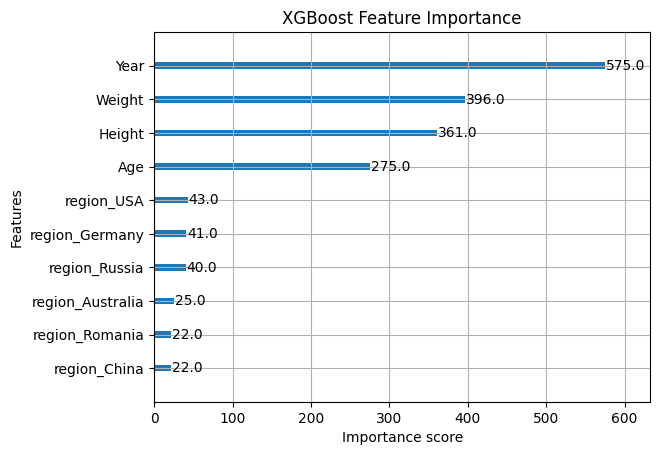

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

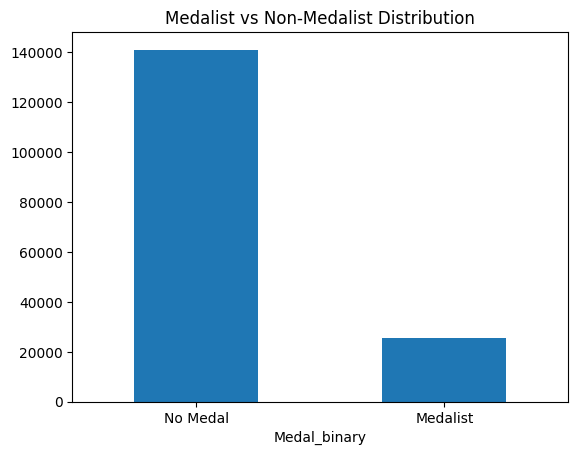

In [15]:
df_model["Medal_binary"].value_counts().plot(kind="bar")
plt.title("Medalist vs Non-Medalist Distribution")
plt.xticks([0,1], ["No Medal", "Medalist"], rotation=0)
plt.show()

In [16]:
## Conclusion

## The results show that both XGBoost and LightGBM can successfully model the Olympic 
## medal outcomes using a small set of basic features.

## Between the two, XGBoost achieved slightly higher accuracy and delivered more 
## interpretable feature importance results.

## The models highlighted region and year as meaningful predictors, reflecting 
## long-term geographic trends in Olympic success, while physical attributes such 
## as height and weight also played a role.

## Overall, gradient-boosting approaches proved to be effective tools for identifying 
## performance patterns in the Olympic dataset, demonstrating how machine learning 
## can extract meaningful insights from over a century of athlete history.